In [1]:
!nvidia-smi

Sun May 28 04:23:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Based on DiffEdit.ipynb https://colab.research.google.com/drive/15t-XM10BDog47J7qxyXO-D-9Qs0dN-wT#scrollTo=Xh7pyvXI1iC-

In [2]:
def install_dependencies():
    !pip install -qq numpy
    !pip install -qq matplotlib
    !pip install -qq fastai
    !pip install -qq accelerate
    !pip install -qq --upgrade transformers diffusers ftfy
    !pip install -qq scipy safetensors

# Uncomment this line if you'd like to install the dependencies. 
install_dependencies()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 112.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 125.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.2 MB/s eta 0:00:00


In [3]:
import os
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from fastcore.all import concat
from fastai.basics import show_image,show_images
from fastdownload import FastDownload
from pathlib import Path

from PIL import Image
import torch, logging
from torch import autocast
from torchvision import transforms as tfms

from huggingface_hub import notebook_login
from transformers import CLIPTextModel,CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL,UNet2DConditionModel,LMSDiscreteScheduler,StableDiffusionInpaintPipeline

import cv2

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# summarize tensor
_s = lambda x: (x.shape,x.max(),x.min())

In [4]:
# # Load RunwayML's Inpainting Model
# inpaint = StableDiffusionInpaintPipeline.from_pretrained('runwayml/stable-diffusion-inpainting',revision="fp16",torch_dtype=torch.float16).to(torch_device)
# Load StabilityAI's Inpainting Model
inpaint = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting",revision="fp16",torch_dtype=torch.float16).to(torch_device)

text_encoder/model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [5]:
def generate_image_mask(input_path, output_img_path, output_mask_path):
    # read the image
    img = cv2.imread(input_path)

    # get the dimensions of the image
    height, width, _ = img.shape

    # calculate the desired patch area
    patch_area = 0.05 * height * width
    print(f'patch_area: {patch_area}')

    # generate random position for the patch
    x = np.random.randint(0, width)
    y = np.random.randint(0, height)

    # generate random number of vertices for the patch
    num_vertices = np.random.randint(3, 7)

    # generate random vertices for the patch until the patch area is reached
    vertices = []
    current_area = 0
    while current_area < 0.05 * patch_area:
        vertex_x = np.random.randint(0, width)
        vertex_y = np.random.randint(0, height)
        vertices.append((vertex_x, vertex_y))
        current_area = cv2.contourArea(np.array(vertices))
        print(f'current_area: {current_area} vs {0.05 * patch_area}')
    #vertices = vertices[:-1]
    # create a white patch image with the same shape as the original image
    patch = np.zeros_like(img)
    cv2.fillPoly(patch, [np.array(vertices)], (255, 255, 255))

    # add the white patch to the image & then convert it to black
    img = cv2.add(img, patch)
    img[img == 255] = 0

    # create a binary mask of the modified image
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(vertices)], 255)

    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
    mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

    cv2.imwrite(output_img_path, img)
    cv2.imwrite(output_mask_path, mask)

In [11]:
input_path = '/content/sq2.jpg'
output_img_path = '/content/sq2_mod.jpg'
output_mask_path = '/content/sq2_mask.jpg'
generate_image_mask(input_path, output_img_path, output_mask_path)
input_image = {}
pil_image = Image.open(output_img_path)
pil_mask = Image.open(output_mask_path)

patch_area: 2528.1
current_area: 0.0 vs 126.405
current_area: 0.0 vs 126.405
current_area: 270.5 vs 126.405


seed: 17


  0%|          | 0/50 [00:00<?, ?it/s]

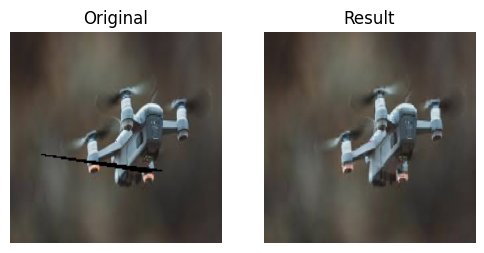

In [12]:
# Now we'll use the mask to do a stable diffusion in painting operation using our target prompt

seed = 17
#seed = torch.seed()
print('seed:',seed)
generator = torch.Generator(torch_device).manual_seed(seed)
im_result = inpaint(prompt=[''],image=pil_image,mask_image=pil_mask,generator=generator).images[0]
show_images([pil_image,im_result],titles=['Original','Result'])